## Part A

DOMAIN:Entertainment  
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the  
• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.  
• PROJECT OBJECTIVE: To build a face detection system.  

In [1]:
#Import imp Libarires
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,classification_report, roc_curve
from tensorflow.keras import optimizers
from keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model




In [2]:
# Loading image.npy file
data = np.load(r'C:\Users\manve\Desktop\Great Learning\CV\images.npy', allow_pickle=True)

(409, 2) (697, 1280, 4)


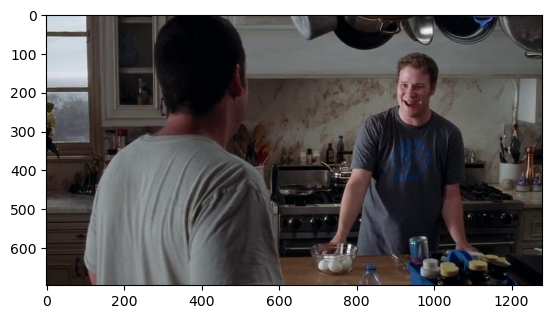

In [3]:
#checking one sample
X = data[1,0]
X.shape
print(data.shape,X.shape)

plt.imshow(X)
plt.show()

In [20]:
im = Image.fromarray(data[0,0].astype(np.uint8))
im.show()

In [21]:
data[3]


array([array([[[  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               ...,
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255]],

              [[  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               ...,
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255]],

              [[  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               ...,
               [  0,   0,   0, 255],
               [  0,   0,   0, 255],
               [  0,   0,   0, 255]],

              ...,

              [[ 80,  31,  18, 255],
               [ 82,  36,  23, 255],
               [ 79,  31,  21, 255],
               ...,
               [121, 114, 104, 255],
               [120, 112, 104, 255],
               [116, 109,  99, 255]],

    

In [22]:
#Set image dimensions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [33]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
     img = data[index][0]
     img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH),
interpolation=cv2.INTER_CUBIC)
     try:
      img = img[:, :, :3]
     except:
      continue
     X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
     for i in data[index][1]:
         x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
         x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
         y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
         y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
         masks[index][y1:y2, x1:x2] = 1


In [34]:
X_train.shape


(409, 224, 224, 3)

In [35]:
masks.shape


(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-0.34901959 -0.75686276 -0.83529413]
  [-0.35686272 -0.7647059  -0.84313726]
  [-0.36470586 -0.74901962 -0.8509804 ]
  ...
  [-0.81960785 -0.88235295 -0.96078432]
  [-0.11372548 -0.08235294 -0.16862744]
  [-0.01960784 -0.06666666 -0.13725489]]

 [

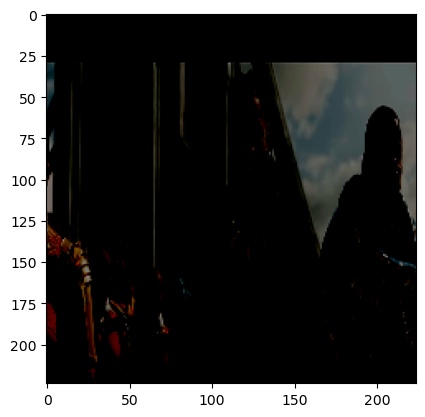

In [37]:
# Image at index 3 is masked
from matplotlib import pyplot

n = 3
print(X_train[n])
pyplot.imshow(X_train[n])


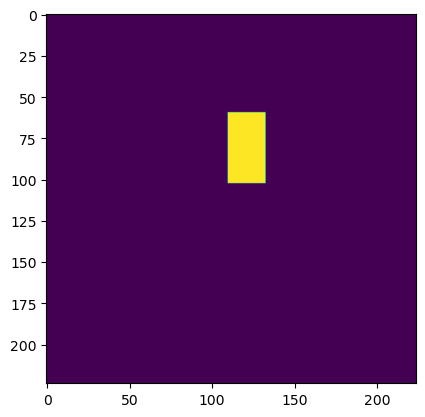

In [38]:
pyplot.imshow(masks[n])


In [40]:
def create_model(trainable=True):
 model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False,
alpha=1, weights="imagenet")
 block0 = model.get_layer("conv_pw_1_relu").output
 block = model.get_layer("conv_pw_1_relu").output
 block1 = model.get_layer("conv_pw_3_relu").output
 block2 = model.get_layer("conv_pw_5_relu").output
 block3 = model.get_layer("conv_pw_11_relu").output
 block4 = model.get_layer("conv_pw_13_relu").output
 x = Concatenate()([UpSampling2D()(block4), block3])
 x = Concatenate()([UpSampling2D()(x), block2])
 x = Concatenate()([UpSampling2D()(x), block1])
 x = Concatenate()([UpSampling2D()(x), block])
 x = UpSampling2D()(x)
 x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
 x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)
 return Model(inputs=model.input, outputs=x)

In [42]:
model1 = create_model(trainable=False)



17235968/17225924 [==============================] - 4s 0us/step


In [43]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [44]:
from keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
 intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
 dice = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) +
K.sum(K.square(y_pred),-1) + smooth)
 return dice


In [45]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
 return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) +
epsilon())

In [46]:
model1.compile(optimizer='adam', loss=loss, metrics= [(dice_coefficient)])


In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=5, min_lr=1e-6,
verbose=1, mode="min")

In [53]:
model1.fit(X_train,masks,
 epochs=10,
 batch_size=1,callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/10
409/409 [==============================] - ETA: 0s - loss: 1.0998 - dice_coefficient: 0.6854
Epoch 1: loss improved from inf to 1.09984, saving model to model-1.10.h5
409/409 [==============================] - 288s 698ms/step - loss: 1.0998 - dice_coefficient: 0.6854 - lr: 0.0010
Epoch 2/10
409/409 [==============================] - ETA: 0s - loss: 0.7353 - dice_coefficient: 0.7560
Epoch 2: loss improved from 1.09984 to 0.73526, saving model to model-0.74.h5
409/409 [==============================] - 287s 702ms/step - loss: 0.7353 - dice_coefficient: 0.7560 - lr: 0.0010
Epoch 3/10
409/409 [==============================] - ETA: 0s - loss: 0.6044 - dice_coefficient: 0.7877
Epoch 3: loss improved from 0.73526 to 0.60437, saving model to model-0.60.h5
409/409 [==============================] - 291s 711ms/step - loss: 0.6044 - dice_coefficient: 0.7877 - lr: 0.0010
Epoch 4/10
409/409 [==============================] - ETA: 0s - loss: 0.4973 - dice_coefficient: 0.8183
Epoch 4: los

Test the model predictions on the test image

In [54]:
idx = 3
x=np.array(X_train[idx])
x=np.expand_dims(x, axis=0)
predict = model1.predict(x, verbose=1)

1/1 [==============================] - 1s 621ms/step


In [55]:
print(predict.shape, predict.min(), predict.max(), predict.mean())


(1, 224, 224) 1.4056983e-15 0.9994116 0.02417164


In [56]:
predict[0]


array([[3.3046544e-07, 3.3046544e-07, 3.1975756e-07, ..., 3.3700448e-07,
        3.3442973e-07, 3.3442973e-07],
       [3.3046544e-07, 3.3046544e-07, 3.1975756e-07, ..., 3.3700448e-07,
        3.3442973e-07, 3.3442973e-07],
       [5.0576330e-07, 5.0576330e-07, 6.5284746e-07, ..., 6.8628117e-07,
        3.7267364e-07, 3.7267364e-07],
       ...,
       [5.7679569e-14, 5.7679569e-14, 6.3852766e-14, ..., 6.5575309e-06,
        3.0162009e-06, 3.0162009e-06],
       [3.6920486e-14, 3.6920486e-14, 3.4538419e-14, ..., 3.2467333e-06,
        2.5123409e-06, 2.5123409e-06],
       [3.6920486e-14, 3.6920486e-14, 3.4538419e-14, ..., 3.2467333e-06,
        2.5123409e-06, 2.5123409e-06]], dtype=float32)

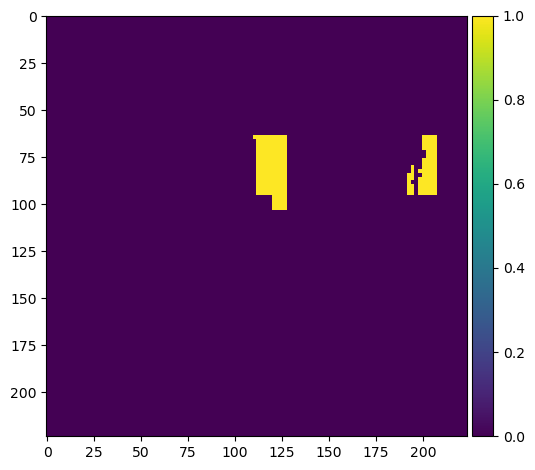

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


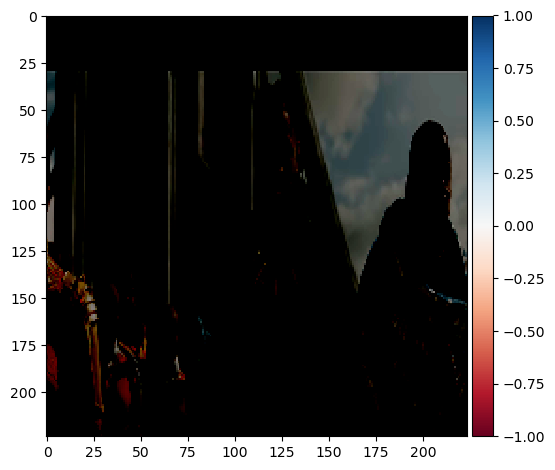

In [57]:
from skimage.io import imread, imshow
predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()
imshow(X_train[idx])
plt.show()


## Part B 

DOMAIN: Entertainment  
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the  
• DATA DESCRIPTION: The dataset comprises of face images.  
• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.  


In [47]:
import cv2
import os
import numpy as np

In [25]:
import os
from os import listdir
from zipfile import ZipFile
with ZipFile(r'C:\Users\manve\Desktop\Great Learning\CV\training_images-20211126T092819Z-001.zip', 'r') as zipObj:
   zipObj.extractall()


In [26]:
# get the path or directory
folder_dir = r"C:\Users\manve\Desktop\Great Learning\CV\training_images"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg")\
        or images.endswith(".jpeg")):
        # display
        print(images)

real_00001.jpg
real_00002.jpg
real_00003.jpg
real_00004.jpg
real_00005.jpg
real_00006.jpg
real_00007.jpg
real_00008.jpg
real_00009.jpg
real_00010.jpg
real_00011.jpg
real_00012.jpg
real_00013.jpg
real_00014.jpg
real_00015.jpg
real_00016.jpg
real_00017.jpg
real_00018.jpg
real_00019.jpg
real_00020.jpg
real_00021.jpg
real_00022.jpg
real_00023.jpg
real_00024.jpg
real_00025.jpg
real_00026.jpg
real_00027.jpg
real_00028.jpg
real_00029.jpg
real_00030.jpg
real_00031.jpg
real_00032.jpg
real_00033.jpg
real_00034.jpg
real_00035.jpg
real_00036.jpg
real_00037.jpg
real_00038.jpg
real_00039.jpg
real_00040.jpg
real_00041.jpg
real_00042.jpg
real_00043.jpg
real_00044.jpg
real_00045.jpg
real_00046.jpg
real_00047.jpg
real_00048.jpg
real_00049.jpg
real_00050.jpg
real_00051.jpg
real_00052.jpg
real_00053.jpg
real_00054.jpg
real_00055.jpg
real_00056.jpg
real_00057.jpg
real_00058.jpg
real_00059.jpg
real_00060.jpg
real_00061.jpg
real_00062.jpg
real_00063.jpg
real_00064.jpg
real_00065.jpg
real_00066.jpg
real_00067

In [224]:
image_path = r"C:\Users\manve\Desktop\Great Learning\CV\training_images"
image_list = os.listdir(r"C:\Users\manve\Desktop\Great Learning\CV\training_images")
for image in image_list:
        img = cv2.imread(r"C:\Users\manve\Desktop\Great Learning\CV\training_images" + image)
        height = 224

        width = img.shape[1]*height/img.shape[0]

        img = cv2.resize(img, (int(width), height), None, 0.5, 0.5, interpolation=cv2.INTER_AREA)
        cv2.imshow('img', img)
        cv2.waitKey(0)


NameError: name 'width' is not defined

In [ ]:
trained_face_data = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_coordinates = trained_face_data.detectMultiScale(gray_img)
    for coordinate in face_coordinates:
        (x, y, w, h) = coordinate
        colors = np.random.randint(1, 255, 3)
        cv2.rectangle(image, (x, y), (x + w, y + h), (int(colors[0]), int(colors[1]), int(colors[2])), thickness=2)
    cv2.imshow('Image', image)
    cv2.waitKey(0)

## Part C

• DOMAIN: Face Recognition  
• CONTEXT: Company X intends to build a face identification model to recognise human faces.  
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.  
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:  

In [50]:
# Import IMP rest using from previous inport
import sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
from sklearn.svm import SVC
random_state = 2020
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')
import pathlib
import PIL
import glob
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tqdm.notebook import tqdm

In [2]:
#Unziping
with ZipFile(r'C:\Users\manve\Desktop\Great Learning\CV\PINS.zip', 'r') as zip:
  zip.extractall()

In [56]:
# Create meta data
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [57]:
metadata

array([PINS\pins_Aaron Paul\Aaron Paul0_262.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_247.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_248.jpg, ...,
       PINS\pins_zendaya\zendaya97.jpg, PINS\pins_zendaya\zendaya98.jpg,
       PINS\pins_zendaya\zendaya99.jpg], dtype=object)

In [58]:
path = str(metadata[210])
path

'PINS\\pins_alexandra daddario\\alexandra daddario61.jpg'

In [59]:
# Load images
def load_image(path):
    img = cv2.imread(path, 1)
    # Images are loaded in BGR order. Reverse them
    return img[...,::-1]

In [60]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

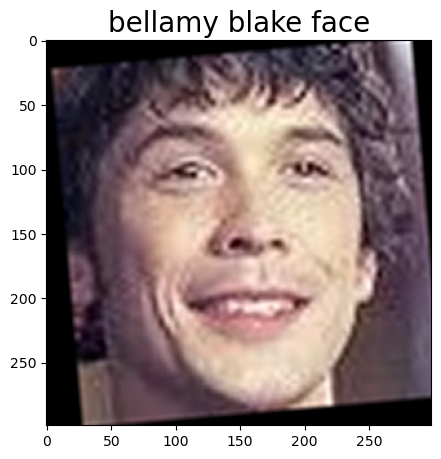

In [61]:
# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(img);

In [62]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model
     

In [64]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_26 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_27 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_33 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                      

In [65]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)


In [66]:
# Generate Embedding vectors for each face in the dataset

img_path = metadata[0].image_path()
img = load_image(img_path)
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224, 224))
print("The shape of the image is {}".format(img.shape))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print("The shape of the Embedded vector is {}".format(embedding_vector.shape))

The shape of the image is (224, 224, 3)
The shape of the Embedded vector is (2622,)


In [67]:
# Generate embeddings
embdngs = []
embdngs = np.zeros((metadata.shape[0], 2622))
for i, meta in t qdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embdngs[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embdngs[i] = np.zeros(2622)

0it [00:00, ?it/s]

In [68]:
#to calculate distance between given 2 pairs of images.
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [69]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

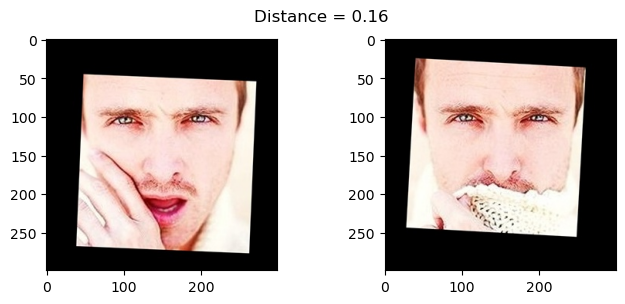

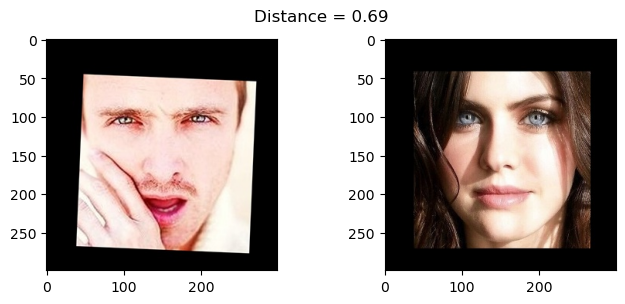

In [70]:
show_pair(2, 3)
show_pair(2, 180)

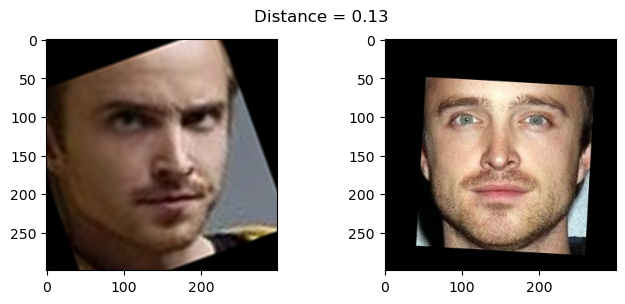

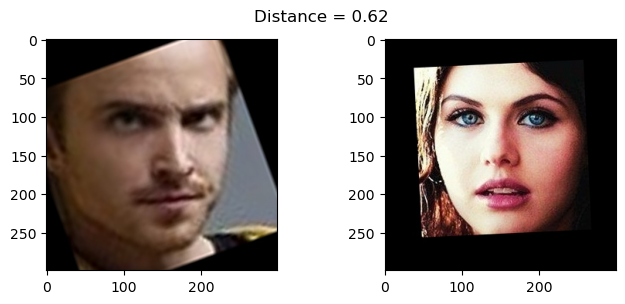

In [71]:
show_pair(30, 31)
show_pair(30, 100)

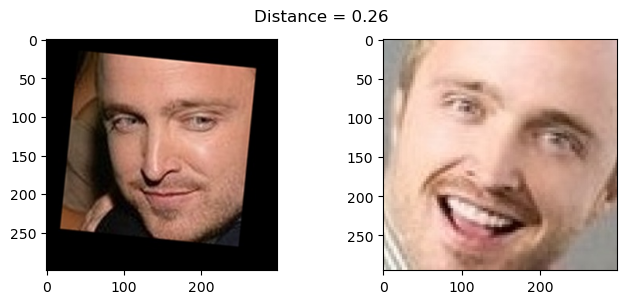

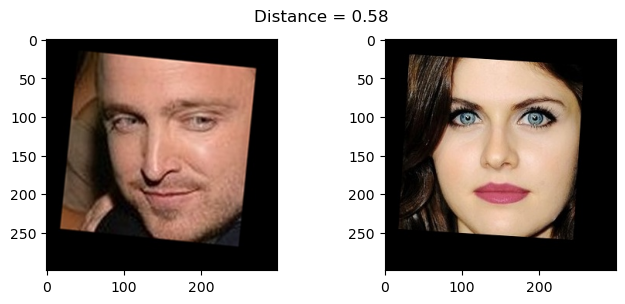

In [72]:
show_pair(70, 72)
show_pair(70, 115)
     

In [96]:
# Split into train and test data
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0
X_train = np.array(embdngs)[train_idx]
X_test = np.array(embdngs)[test_idx]
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])
print("Shapes of train and test data are {}, {}, {} and {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Shapes of train and test data are (9573, 2622), (1197, 2622), (9573,) and (1197,)


In [97]:
# Label encoding
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [98]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [99]:
# Covariance matrix
cvar_mat = np.cov(X_train_sc.T)
print("Shape of Covariance Matrix:",cvar_mat.shape)
eigen_vals, eigen_vecs = np.linalg.eig(cvar_mat)
tot = sum(eigen_vals)
var_exp = [(i /tot) * 100 for i in sorted(eigen_vals, reverse = True)]
cvar_exp = np.cumsum(var_exp)
print('Explained Cumulative Variance is ', cvar_exp)

Shape of Covariance Matrix: (2622, 2622)
Explained Cumulative Variance is  [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [100]:
# Get index where cumulative variance explained is > threshold
thresh = 95
res = list(filter(lambda i: i > thresh, cvar_exp))[0]
index = (cvar_exp.tolist().index(res))
print(f'Index of element just greater than {thresh}: {str(index)}')

Index of element just greater than 95: 346


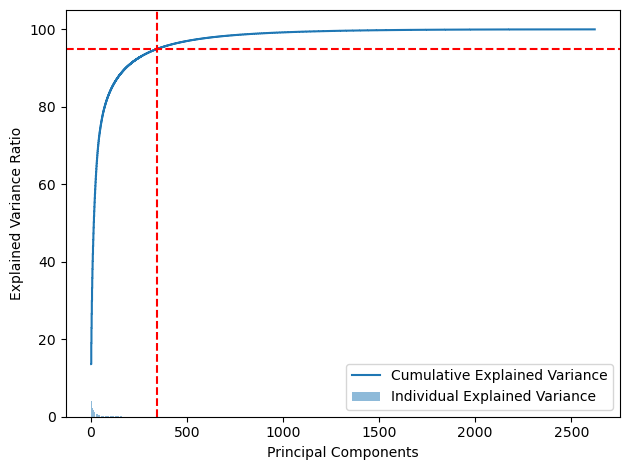

In [101]:

# Plotting explained variance
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(1, eigen_vals.size + 1), cvar_exp, where = 'mid', label = 'Cumulative Explained Variance')
plt.axhline(y = thresh, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [102]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 7, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
print("Shape of dimensionally reduced data {}, {}".format(X_train_pca.shape, X_test_pca.shape))


Shape of dimensionally reduced data (9573, 346), (1197, 346)


In [103]:
svc = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 7)
svc.fit(X_train_pca, y_train)
print('SVC accuracy for train dataset is: {0:.2f}'.format(svc.score(X_train_pca, y_train)))


SVC accuracy for train dataset is: 0.99


In [104]:

# Predict
y_pred = svc.predict(X_test_pca)
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(2)))

Accuracy Score: 0.97


In [107]:
# Classification Report
names = [name.split('_')[1].title().strip() for name in labels]
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

In [147]:
# Create meta data
class t_IdentityMetadata():
    def __init__(self, base, name, file):
#         print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.t_image_path()

    def t_image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def t_load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(t_IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = t_load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [168]:
# Load images
def t_load_image(path):
    img = cv2.imread(path, 1)
    print(path)
    # Images are loaded in BGR order. Reverse them
    return img[...,::-1]

In [169]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].t_image_path()
img = t_load_image(img_path)

PINS\pins_taylor swift\taylor swift24.jpg


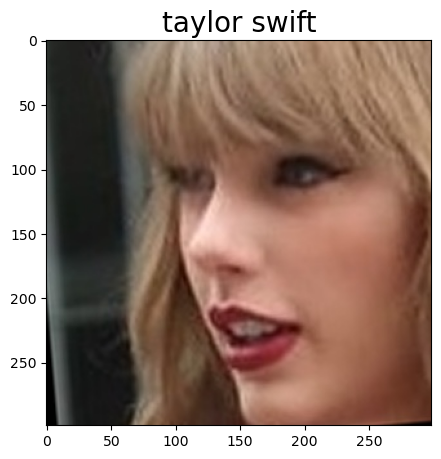

In [170]:
# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(img);

In [171]:
t1_idx = np.arange(metadata.shape[0]) % 9 == 0
t2_idx = np.arange(metadata.shape[0]) % 9 == 1

In [210]:
def sample_img_plot(sample_idx):
  # Load image
  test1_image_path =r'C:\Users\manve\Desktop\Great Learning\CV\Benedict+Cumberbatch9.jpg'
  sample_img = t_load_image(test1_image_path)
  actual_name = metadata[t1_idx][sample_idx].name.split('_')[-1].title().strip()
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  pred_name = enc.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

C:\Users\manve\Desktop\Great Learning\CV\Benedict+Cumberbatch9.jpg


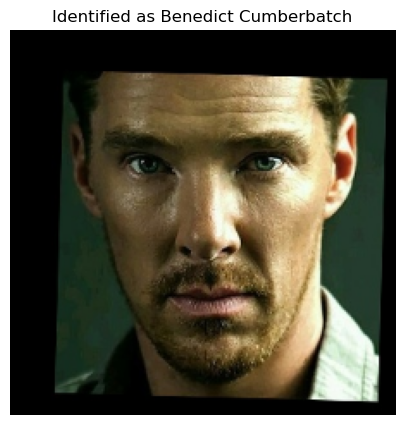

In [219]:
# Plot for images
sample_img, actual_name, pred_name = sample_img_plot(0)
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f'Identified as {pred_name}');
plt.show()



In [221]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  test1_image_path =r'C:\Users\manve\Desktop\Great Learning\CV\Dwayne+Johnson4.jpg'
  sample_img = t_load_image(test1_image_path)
  actual_name = metadata[t1_idx][sample_idx].name.split('_')[-1].title().strip()
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  pred_name = enc.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

C:\Users\manve\Desktop\Great Learning\CV\Dwayne+Johnson4.jpg


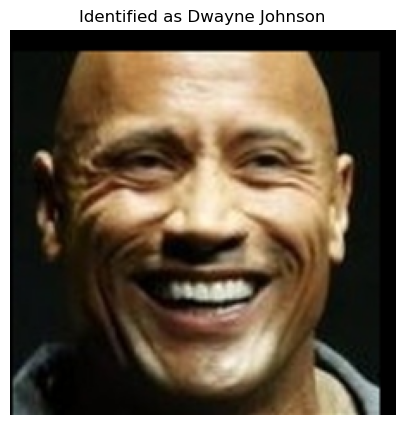

In [222]:
# Plot for images
sample_img, actual_name, pred_name = sample_img_plot(0)
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f'Identified as {pred_name}');
plt.show()